# Closed system simulation with experimental data markers

In this simulation we have a system of 5 liters in which we start with Next = 1000, some Nint (measured) of some mass (m). After this we "feed" for a period of 3.5 days, i.e. solve the "feeding" part of the simulation. After that, we add 1000 uM to the last value of Next and keep "feeding". After one duration (7 days) we reset the water, mass and the amplitude to the beginning of the first cycle. The only difference from the t_0 is the Nint which is accumulating all the effects through the time. The mass is reset to m_0 and Next is reset to 1000 ppm (per something per something)


In [1]:
# N_simulation
from __future__ import division
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd # to read excel
%matplotlib inline

from myfunctions import *


# from datetime import datetime

In [2]:
xl = pd.ExcelFile('../data/input_format.xlsx')

df1 = xl.parse('Parameters',header=None)
df2 = xl.parse('500.2.3.168')#header=None)


# which parameters? and values we read? if you want to print, uncomment:
# print(df.iloc[:][0],df.iloc[:][1])

# assigmment of parameters to values: 
for key,val in zip(df1.iloc[:][0],df1.iloc[:][1]):
    exec(key + '=val')
    print(key,val)
    

Amplitude = 500
Period = 2.333

dNextoutdt 0.03
dNextindt 0.0
dmoutdt 0.0
miu 0.014583333333333332
Nintmax 4.23
Nintmin 1.0
NH4max 100.0
NH4min 0.0
KNH4 10.0
KN 2.0
Ks 14.0
Vmax 60.0
Vassim 60.0
Next0 0.0
NH40 0.0
Nint0 1.85
m0 0.15
Amplitude 500.0
Duration 7.0
Period 3.5
Kd 0.4
Nintcrit 3.0


In [3]:
df2.head()

,day i,day f,sleeve,parameter,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,03.10.19,24.10.19,7.0,Time,22.10.2019 07:00,24.10.2019 09:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Next,41.3182,23.3848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,Time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Nint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Time,03.10.19 11:30,06.10.19 10:00,08.10.19 12:00,10.10.19 11:30,10.10.19 12:30,13.10.19 08:00,15.10.19 10:45,17.10.19 10:00,17.10.19 11:00,20.10.19 10:00,22.10.19 08:00,24.10.19 12:00


In [4]:
df2.tail()

,day i,day f,sleeve,parameter,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
13,NaN,NaN,NaN,Next,86.9002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,Time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,Nint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,Time,03.10.19 11:30,06.10.19 10:00,08.10.19 12:00,10.10.19 11:30,10.10.19 12:30,13.10.19 08:00,15.10.19 10:45,17.10.19 10:00,17.10.19 11:00,20.10.19 10:00,22.10.19 08:00,24.10.19 12:00
17,NaN,NaN,NaN,m,0.15,0.141,0.147,0.207,0.15,0.24,0.366,0.45,0.15,0.291,0.384,0.441


In [5]:
# find out how many experiments are in the file
n_exp = df2['day i'].dropna().shape[0] # number of items that have day i property and not NaN

# it should be equal to the number of day f - just for a test. will pop an error if the file is corrupted
assert (n_exp == df2['day f'].dropna().shape[0])

print('N of experiments = {}'.format(n_exp))

N of experiments = 3


In [6]:
day_i = df2['day i'].dropna()
day_i.astype('S')

0     b'03.10.19'
6     b'03.10.19'
12    b'03.10.19'
Name: day i, dtype: bytes64

In [7]:
# find out the sleeve number in each experiment
sleeves = df2['sleeve'].dropna().astype(int)
for s in sleeves:
    print('sleeve {}'.format(s))

sleeve 7
sleeve 8
sleeve 9


In [8]:
ind_Nint = df2.index[df2['parameter'] == 'Nint'] # find index of the Nint rows
print(ind_Nint) # print it for the reference, these are rows 2, 6 and 10

# small test
assert(len(ind_Nint) == n_exp) # if we found less Nint than experiments, then something is wrong


df2.iloc[ind_Nint[1],4:].dropna() # take the 2nd element of that index, i.e. 2nd experiment and show the data:

Int64Index([3, 9, 15], dtype='int64')


Unnamed: 4        3
Unnamed: 5     2.27
Unnamed: 6     3.47
Unnamed: 8     4.02
Unnamed: 9     3.16
Unnamed: 10    1.92
Unnamed: 11    3.96
Unnamed: 12    3.78
Name: 9, dtype: object

In [9]:
ind_Next = df2.index[df2['parameter'] == 'Next'] # find index of the Next 
Next_measurement_times = pd.to_datetime(df2.iloc[ind_Next[0]-1,4:].dropna(),dayfirst=True)
print(Next_measurement_times)

Unnamed: 4   2019-10-22 07:00:00
Unnamed: 5   2019-10-24 09:30:00
Name: 0, dtype: datetime64[ns]


In [10]:
# plot all sleeves data
ind_m = df2.index[df2['parameter'] == 'm'] # find index of the mass was measured (this is the only data available so far)

# small test
assert(len(ind_m) == n_exp) # if we found less Nint than experiments, then something is wrong


# fig,ax = plt.subplots(figsize=(12,10))

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('mass');

m_all, m_times_all, Nint_all, Nint_times_all, Next_all, Next_times_all = [], [], [], [], [], []

for counter,value in enumerate(ind_m):
    m = df2.iloc[value,4:]
    val = []
    for number in m:
        a=~np.isnan(number)
        val.append(a)
    m = df2.iloc[value,4:][val] #'value' gives row number, '4:' goes column by column starting at 4,'val' keeps only non NaNs
    m_measurement_times = pd.to_datetime(df2.iloc[value-1,4:][val],dayfirst=True)
    print(m_measurement_times)
    hours = pd.Series((m_measurement_times - m_measurement_times[0]).astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    print(counter, label)
 #   ax.plot(hours,m,':o',label=label,lw=2)
    
    for sample in m:
        m_all.append(sample)
        
    for h in hours:
        m_times_all.append(h)
        
# ax.legend()
# ax.set_xlabel('Time (hours)')
# ax.set_ylabel('mass (g DW / l)');

Unnamed: 4    2019-10-03 11:30:00
Unnamed: 5    2019-10-06 10:00:00
Unnamed: 6    2019-10-08 12:00:00
Unnamed: 7    2019-10-10 11:30:00
Unnamed: 8    2019-10-10 12:30:00
Unnamed: 9    2019-10-13 08:00:00
Unnamed: 10   2019-10-15 10:45:00
Unnamed: 11   2019-10-17 10:00:00
Unnamed: 12   2019-10-17 11:00:00
Unnamed: 13   2019-10-20 10:00:00
Unnamed: 14   2019-10-22 08:00:00
Unnamed: 15   2019-10-24 12:00:00
Name: 4, dtype: datetime64[ns]
0 03.10.19 sleeve7
Unnamed: 4    2019-10-03 11:30:00
Unnamed: 5    2019-10-06 10:00:00
Unnamed: 6    2019-10-08 12:00:00
Unnamed: 7    2019-10-10 11:30:00
Unnamed: 8    2019-10-10 12:30:00
Unnamed: 9    2019-10-13 08:00:00
Unnamed: 10   2019-10-15 10:45:00
Unnamed: 11   2019-10-17 10:00:00
Unnamed: 12   2019-10-17 11:00:00
Unnamed: 13   2019-10-20 10:00:00
Unnamed: 14   2019-10-22 08:00:00
Unnamed: 15   2019-10-24 12:00:00
Name: 10, dtype: datetime64[ns]
1 03.10.19 sleeve8
Unnamed: 4    2019-10-03 11:30:00
Unnamed: 5    2019-10-06 10:00:00
Unnamed: 6    2

In [11]:
# plot all sleeves data
ind_Nint = df2.index[df2['parameter'] == 'Nint'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_Nint) == n_exp) # if we found less Nint than experiments, then something is wrong

# fig,ax = plt.subplots(figsize=(12,10))

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Nint');

Nint_all, Nint_times_all = [], []
for counter,value in enumerate(ind_Nint):
    Nint = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Nint:
        a=~np.isnan(number)
        val.append(a)
    Nint = df2.iloc[value,4:][val]
    Nint_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Nint_measurement_times - Nint_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
#    ax.plot(hours,Nint,':o',label=label,lw=2)
    
    for sample in Nint:
        Nint_all.append(sample)
    
    for h in hours:
        Nint_times_all.append(h)
        
# ax.legend()
# ax.set_xlabel('Time (hours)')
# ax.set_ylabel('Nint (% g N / g DW)');

In [12]:
Nint_all, Nint_times_all

([3, 2.27, 3.47, 4.02, 3.16, 1.92, 3.96, 3.78],
 [0.0, 70.0, 120.0, 236.0, 287.0, 334.0, 406.0, 504.0])

In [13]:
# plot all sleeves data
ind_Next = df2.index[df2['parameter'] == 'Next'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_Next) == n_exp) # if we found less Nint than experiments, then something is wrong

#fig,ax = plt.subplots(figsize=(12,10))

#plt.legend()
#plt.xlabel('Time')
#plt.ylabel('Next');

Next_all, Next_times_all = [], []
for counter,value in enumerate(ind_Next):
    Next = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Next:
        a=~np.isnan(number)
        val.append(a)
    Next = df2.iloc[value,4:][val]
    Next_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Next_measurement_times - Next_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
#    ax.plot(hours,Next,':o',label=label,lw=2)
    
    for sample in Next:
        Next_all.append(sample)
    
    for h in hours:
        Next_times_all.append(h)
        
#ax.legend()
#ax.set_xlabel('Time (hours)')
#ax.set_ylabel('Next (umol N / l)');

In [14]:
# now combine the two:
# decide how many cycles you want, e.g. 10 days, with a daily feeding
NEXT, NINT, M, T = [],[],[],[]

n_days = Duration*3

for hour in np.arange(0,n_days*24,Period*24):
    print(hour)
    
    if hour == 0:
        print('Starting point')
        Nint_0 = Nint0
        m_0 = m0
        Next_0 = Amplitude
    
    if hour > 0 and np.mod(hour,Period*24) == 0:
        if np.mod(hour,Duration*24) == 0:
            print('Duration')
            # reset everything, except Nint
            Nint_0 = NINT[-1][-1]
            Next_0 = Amplitude
            m_0 = m0
        else:    
            # period passed, not Duration
            # add amplitude, keep going 
            print('Period')
            Next_0 = NEXT[-1][-1] + Amplitude
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]

        
    # setup initial conditions
    x0 = [Next_0,Nint_0,m_0]
    
    t = np.linspace(hour,hour+Period*24)
    x = odeint(N_feeding_original,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,KN,dNextoutdt,dNextindt,miu,dmoutdt))

    NEXT.append(x[: , 0])
    NINT.append(x[: , 1])
    M.append(x[: , 2])
    T.append(t)
    
    t_model = np.hstack(T)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)

0.0
Starting point
55.992000000000004
Period
111.98400000000001
Period
167.976
223.96800000000002
Period
279.96000000000004
335.952
391.944
447.93600000000004
Period
503.92800000000005


## Read the experimental data from the same file, second sheet

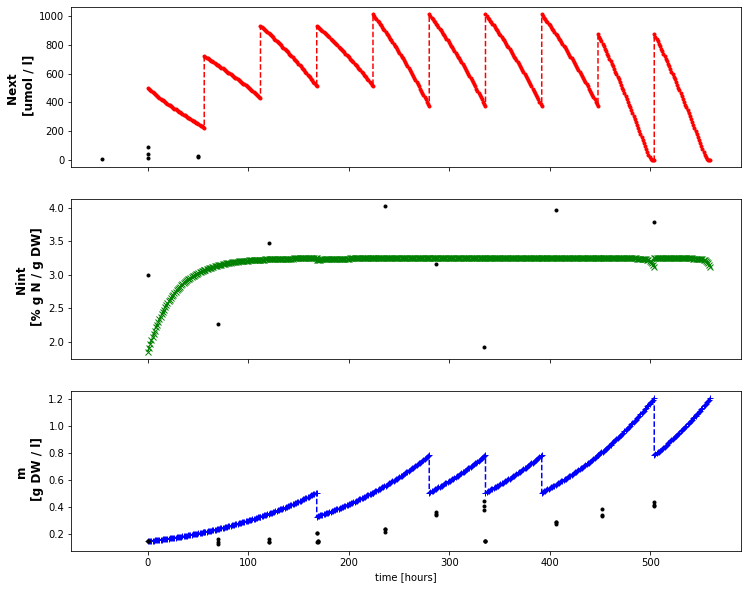

In [15]:
plot_result(t_model,Next_model,Nint_model,m_model,Nint=Nint_all,tNint=Nint_times_all,m=m_all,tm=m_times_all,Next=Next_all,tNext=Next_times_all)

In [16]:
print(len(m_all))
#sorted(m_all)
print(min(m_all))


36
0.132


In [17]:
sporulation_indices = [i for i, x in enumerate(m_all) if x <= 0.15]
print(sporulation_indices)
m_no_sporulation = m_all
m_times_no_sporulation = m_times_all

for i in range(len(sporulation_indices) - 1, -1,-1):
    print(i)
    print(m_no_sporulation[sporulation_indices[i]])
    del m_no_sporulation[sporulation_indices[i]]
    print(m_times_no_sporulation[sporulation_indices[i]])
    del m_times_no_sporulation[sporulation_indices[i]]
#print (len(m_no_sporulation), len(m_times_no_sporulation))
#m_all_non_sporulation = m_all(non_sporulation_indices)
#m_no_sporulation

print(min(m_no_sporulation))

sporulation_indices2 = [i for i, t in enumerate(sporulation_indices) if [t < 10 or 158 < t < 178 or 326 < t < 346]]
print(sporulation_indices2)

for i in range(len(sporulation_indices2) - 1, -1,-1):
    print(i)
    print(m_no_sporulation[sporulation_indices2[i]])
    del m_no_sporulation[sporulation_indices2[i]]
    print(m_times_no_sporulation[sporulation_indices2[i]])
    del m_times_no_sporulation[sporulation_indices2[i]]

[4, 8, 12, 13, 14, 15, 16, 20, 24, 25, 26, 28, 32]
12
0.15
335.0
11
0.15
169.0
10
0.14700000000000002
120.0
9
0.14100000000000001
70.0
8
0.15
0.0
7
0.15
335.0
6
0.14100000000000001
169.0
5
0.14700000000000002
168.0
4
0.14700000000000002
120.0
3
0.132
70.0
2
0.15
0.0
1
0.15
335.0
0
0.15
169.0
0.153
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
12
0.378
334.0
11
0.348
287.0
10
0.216
236.0
9
0.41400000000000003
504.0
8
0.345
452.0
7
0.291
406.0
6
0.411
334.0
5
0.345
287.0
4
0.24
236.0
3
0.20700000000000002
168.0
2
0.162
120.0
1
0.162
70.0
0
0.153
0.0


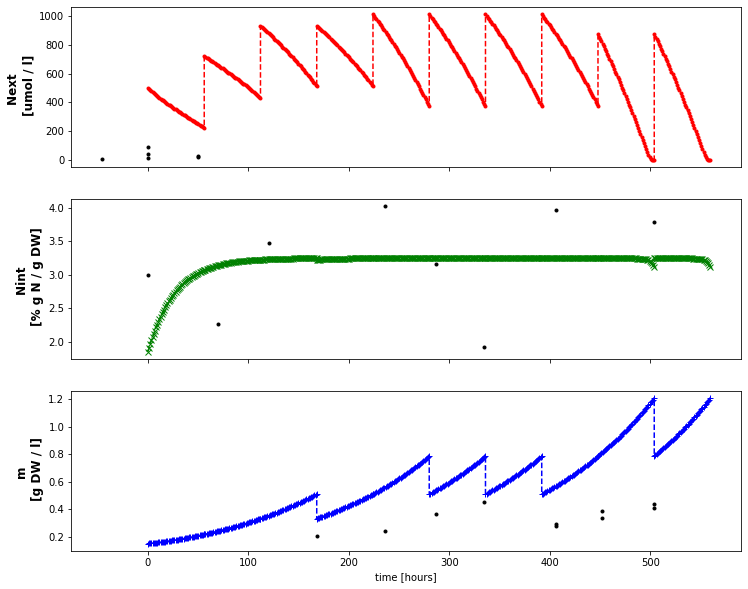

In [18]:
plot_result(t_model,Next_model,Nint_model,m_model,Nint=Nint_all,tNint=Nint_times_all,m=m_no_sporulation,tm=m_times_no_sporulation,Next=Next_all,tNext=Next_times_all)